In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.stats import ttest_ind
import subprocess
import sys

def install_python_louvain():
    try:
        import community as community_louvain
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "python-louvain"])
    
# Required to import the lovain library -> added this since import is a bit counterintuitive :)
install_python_louvain()
import community as community_louvain

import warnings
warnings.filterwarnings("ignore")


def load_trade_data(data_path: str, hs_code: int, start_year: int, end_year: int) -> (pd.DataFrame, list[int]):
    """
    Load and preprocess trade data for a specific HS code and year range.
    
    Parameters:
        data_path (str): Path to the trade data CSV file.
        hs_code (int): HS code for the commodity of interest.
        start_year (int): Start year for the analysis.
        end_year (int): End year for the analysis.
    
    Returns:
        df_filtered (DataFrame): Filtered DataFrame containing relevant trade data.
        years (list): List of years in the filtered data.
    """

    df = pd.read_csv(data_path, low_memory=False)
    
    df_filtered = df[df['k'] == hs_code]
    df_filtered.dropna(subset=['q'], inplace=True) # TO DO: Think of a better approach to handle these (fillna potentially?)
    
    df_filtered = df_filtered[(df_filtered['t'] >= start_year) & (df_filtered['t'] <= end_year)]
    
    years = sorted(df_filtered['t'].unique())
    
    return df_filtered, years


def build_trade_networks(df_filtered: pd.DataFrame, years: list) -> dict[nx.DiGraph]:
    """
    Build trade networks for each year.
    
    Parameters:
        df_filtered (DataFrame): Filtered trade data.
        years (list): List of years to build networks for.
    
    Returns:
        graphs (dict): Dictionary of NetworkX graphs keyed by year.
    """
    graphs = {}
    for year in years:
        df_year = df_filtered[df_filtered['t'] == year]
        G = nx.DiGraph()
        for idx, row in df_year.iterrows():
            exporter = row['export_country']
            importer = row['import_country']
            quantity = row['q']

            if quantity > 0:
                G.add_edge(exporter, importer, weight=quantity)
        graphs[year] = G
    return graphs


def compute_centrality_measures(graphs: dict[nx.DiGraph], country_name: str) -> (dict[float], pd.DataFrame):
    """
    Compute centrality measures for each graph and extract metrics for a specific country.
    
    Parameters:
        graphs (dict): Dictionary of NetworkX graphs keyed by year.
        country_name (str): Name of the country to extract metrics for.
    
    Returns:
        centrality_measures (dict): Dictionary of centrality measures for each year.
        country_metrics_df (DataFrame): DataFrame containing the country's metrics over time.
    """
    
    centrality_measures = {}
    country_metrics = []
    
    for year, G in graphs.items():

        degree_centrality = nx.degree_centrality(G)
        in_degree_centrality = G.in_degree(weight='weight')
        out_degree_centrality = G.out_degree(weight='weight')
        betweenness_centrality = nx.betweenness_centrality(G, weight='weight', normalized=True)
        closeness_centrality = nx.closeness_centrality(G)
        clustering_coefficient = nx.clustering(G.to_undirected())
        
        centrality_measures[year] = {
            'degree_centrality': degree_centrality,
            'in_degree_centrality': dict(in_degree_centrality),
            'out_degree_centrality': dict(out_degree_centrality),
            'betweenness_centrality': betweenness_centrality,
            'closeness_centrality': closeness_centrality,
            'clustering_coefficient': clustering_coefficient
        }
        
        country_degree = degree_centrality.get(country_name, np.nan)
        country_in_degree = centrality_measures[year]['in_degree_centrality'].get(country_name, np.nan)
        country_out_degree = centrality_measures[year]['out_degree_centrality'].get(country_name, np.nan)
        country_betweenness = betweenness_centrality.get(country_name, np.nan)
        country_closeness = closeness_centrality.get(country_name, np.nan)
        country_clustering = clustering_coefficient.get(country_name, np.nan)
        
        country_metrics.append({
            'Year': year,
            'DegreeCentrality': country_degree,
            'InDegreeCentrality': country_in_degree,
            'OutDegreeCentrality': country_out_degree,
            'BetweennessCentrality': country_betweenness,
            'ClosenessCentrality': country_closeness,
            'ClusteringCoefficient': country_clustering
        })
    
    country_metrics_df = pd.DataFrame(country_metrics)
    country_metrics_df.dropna(inplace=True)
    
    return centrality_measures, country_metrics_df


def perform_statistical_tests(country_metrics_df: pd.DataFrame, pre_treatment_year: list[int], treatment_years: list[int]) -> dict[float]:
    """
    Perform t-tests on centrality measures between pre-treatment and treatment periods.
    
    Parameters:
        country_metrics_df (DataFrame): DataFrame containing the country's metrics over time.
        pre_treatment_years (list): List of years in the pre-treatment period.
        treatment_years (list): List of years in the treatment period.
    
    Returns:
        test_results (dict): Dictionary containing t-statistics and p-values for each metric.
    """
    country_metrics_df['Era'] = country_metrics_df['Year'].apply(lambda x: 'Pre-Treatment' if x in pre_treatment_years else 'Treatment')
    
    metrics = ['DegreeCentrality', 'BetweennessCentrality', 'ClosenessCentrality', 'ClusteringCoefficient']
    test_results = {}
    
    print("\nStatistical Tests:")
    for metric in metrics:
        pre_values = country_metrics_df[country_metrics_df['Era'] == 'Pre-Treatment'][metric]
        treat_values = country_metrics_df[country_metrics_df['Era'] == 'Treatment'][metric]
        
        if len(pre_values) < 2 or len(treat_values) < 2:
            print(f"Not enough data to perform t-test for {metric}.")
            continue
        
        t_stat, p_value = ttest_ind(pre_values, treat_values, equal_var=False)
        test_results[metric] = {'t_statistic': t_stat, 'p_value': p_value}
        print(f"T-test for {metric}: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")
    
    return test_results


def visualize_centrality_measures(country_metrics_df: pd.DataFrame, country_name: str) -> None:
    """
    Plot centrality measures over time for a specific country.
    
    Parameters:
        country_metrics_df (DataFrame): DataFrame containing the country's metrics over time.
        country_name (str): Name of the country.
    """
    plt.figure(figsize=(12, 8))
    plt.plot(country_metrics_df['Year'], country_metrics_df['DegreeCentrality'], marker='o', label='Degree Centrality')
    plt.plot(country_metrics_df['Year'], country_metrics_df['BetweennessCentrality'], marker='s', label='Betweenness Centrality')
    plt.plot(country_metrics_df['Year'], country_metrics_df['ClosenessCentrality'], marker='^', label='Closeness Centrality')
    plt.plot(country_metrics_df['Year'], country_metrics_df['ClusteringCoefficient'], marker='d', label='Clustering Coefficient')
    plt.title(f'{country_name} Centrality Measures Over Time')
    plt.xlabel('Year')
    plt.ylabel('Centrality Measure')
    plt.legend()
    plt.grid(True)
    plt.show()


def visualize_network(graphs: dict[nx.DiGraph], year: int, target_country: str) -> None:
    """
    Visualize the trade network for a specific year and highlight a target country.
    
    Parameters:
        graphs (dict): Dictionary of NetworkX graphs keyed by year.
        year (int): Year to visualize.
        target_country (str): Country to highlight in the network.
    """
    G = graphs[year]
    if G.number_of_nodes() == 0:
        print(f"No nodes in the graph for year {year}. Cannot visualize.")
        return
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(14, 10))
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color='skyblue')
    nx.draw_networkx_edges(G, pos, edge_color='gray', arrowsize=10, width=0.5)
    # Highlight the target country
    if target_country in G.nodes():
        nx.draw_networkx_nodes(G, pos, nodelist=[target_country], node_color='red', node_size=200)
        nx.draw_networkx_labels(G, pos, labels={target_country: target_country}, font_color='red', font_weight='bold')
    else:
        print(f"'{target_country}' not found in the graph for year {year}.")
    plt.title(f"Trade Network {year}")
    plt.axis('off')
    plt.show()


def detect_and_analyze_communities(graphs: dict[nx.DiGraph], country_name: str) -> pd.DataFrame:
    """
    Detect communities using the Louvain method and analyze the country's community assignments over time.
    
    Parameters:
        graphs (dict): Dictionary of NetworkX graphs keyed by year.
        country_name (str): Name of the country to analyze.
    
    Returns:
        us_community_df (DataFrame): DataFrame containing the country's community assignments over time.
    """

    us_communities = {}
    for year, G in graphs.items():
        if G.number_of_nodes() == 0:
            print(f"No nodes in the graph for year {year}. Cannot perform community detection.")
            us_communities[year] = None
            continue

        G_undirected = G.to_undirected()

        partition = community_louvain.best_partition(G_undirected)

        num_communities = len(set(partition.values()))
        print(f"Year {year}: Detected {num_communities} communities.")

        us_community = partition.get(country_name, None)
        us_communities[year] = us_community

    us_community_df = pd.DataFrame(list(us_communities.items()), columns=['Year', 'Community'])

    us_community_df['Community'] = us_community_df['Community'].fillna('Not Assigned')
    us_community_df['Community'] = us_community_df['Community'].astype(str)

    us_community_df = us_community_df.sort_values('Year')

    return us_community_df


def analyze_trade_network(data_path: str, hs_code: int, country_name: str, pre_treatment_years: list[int], treatment_years: list[int]):
    """
    Analyze the trade network for a specific HS code and country, comparing pre-treatment and treatment periods.
    
    Parameters:
        data_path (str): Path to the trade data CSV file.
        hs_code (int): HS code for the commodity of interest.
        country_name (str): Name of the country to analyze.
        pre_treatment_years (list): List of years in the pre-treatment period.
        treatment_years (list): List of years in the treatment period.
    """

    start_year = min(pre_treatment_years + treatment_years)
    end_year = max(pre_treatment_years + treatment_years)
    df_filtered, years = load_trade_data(data_path, hs_code, start_year, end_year)
    

    unique_countries = set(df_filtered['export_country'].unique()).union(set(df_filtered['import_country'].unique()))
    if country_name not in unique_countries:
        print(f"{country_name} not found in the trade data for HS code {hs_code} between {start_year} and {end_year}.")
        return
    
    graphs = build_trade_networks(df_filtered, years)
    
    centrality_measures, country_metrics_df = compute_centrality_measures(graphs, country_name)
    
    if country_metrics_df.empty:
        print(f"No centrality measures available for {country_name}. Cannot proceed with the analysis.")
        return
    
    test_results = perform_statistical_tests(country_metrics_df, pre_treatment_years, treatment_years)
    
    visualize_centrality_measures(country_metrics_df, country_name)
    
    visualize_network(graphs, pre_treatment_years[-1], country_name)
    visualize_network(graphs, treatment_years[0], country_name)
    
    detect_and_analyze_communities(graphs, country_name)
    
    return test_results


Statistical Tests:
T-test for DegreeCentrality: t-statistic = -3.6643, p-value = 0.0088
T-test for BetweennessCentrality: t-statistic = -1.8325, p-value = 0.1002
T-test for ClosenessCentrality: t-statistic = -2.3421, p-value = 0.0471
T-test for ClusteringCoefficient: t-statistic = 3.4089, p-value = 0.0080


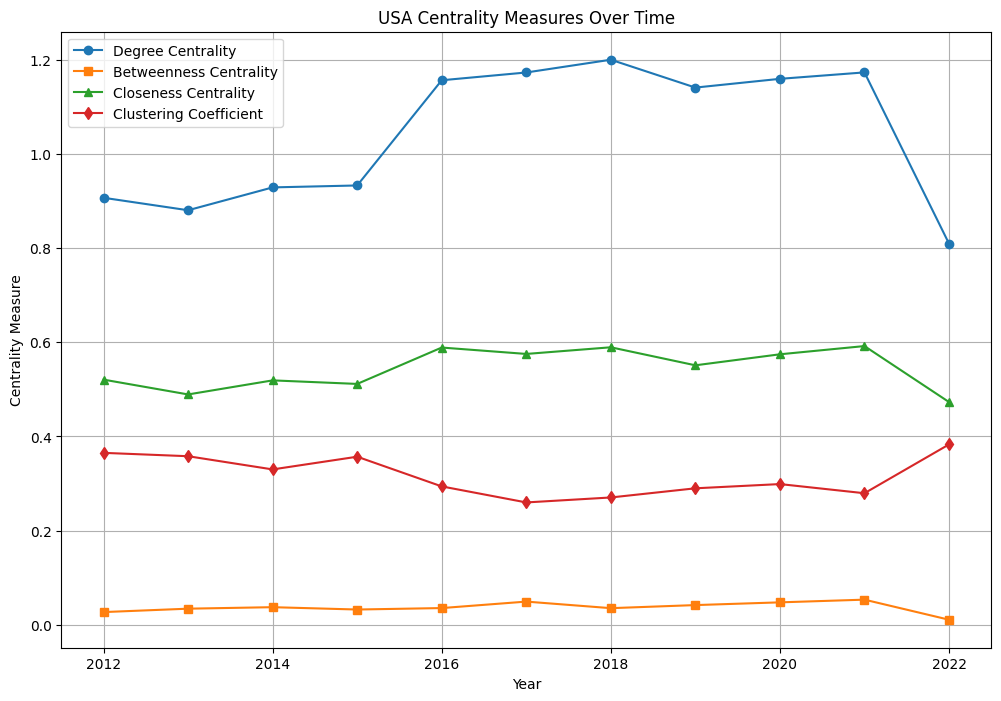

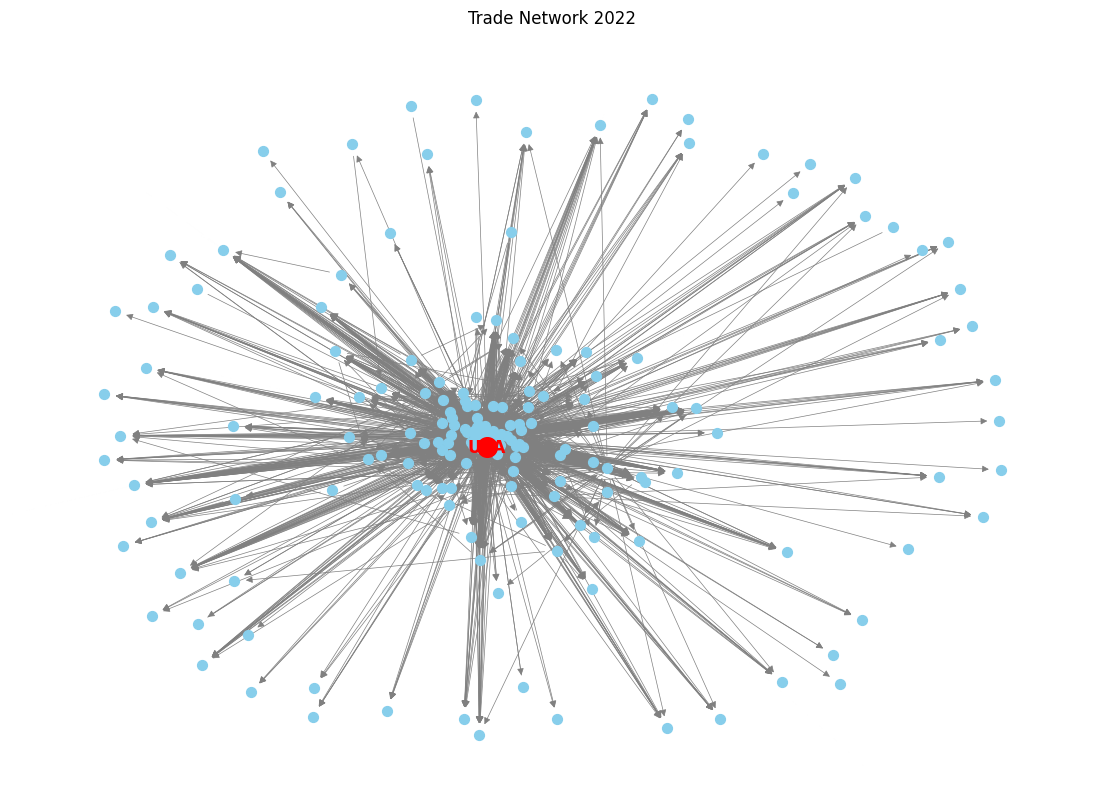

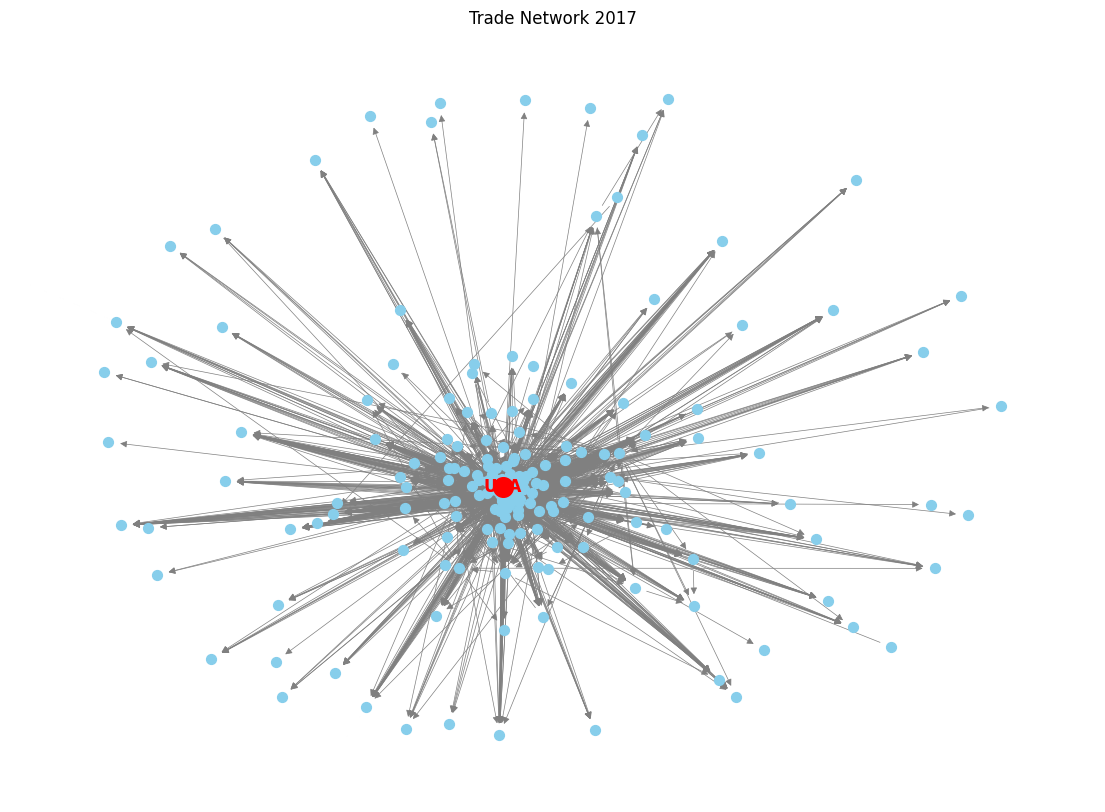

Year 2012: Detected 6 communities.
Year 2013: Detected 5 communities.
Year 2014: Detected 4 communities.
Year 2015: Detected 4 communities.
Year 2016: Detected 5 communities.
Year 2017: Detected 4 communities.
Year 2018: Detected 6 communities.
Year 2019: Detected 4 communities.
Year 2020: Detected 6 communities.
Year 2021: Detected 4 communities.
Year 2022: Detected 4 communities.


In [2]:
################
# Semiconductors
################
data_path = os.path.join(os.getcwd(), "basedata", "base_data.csv")
hs_code = 853400
country_name = 'USA'
pre_treatment_years = [2012, 2013, 2014, 2015, 2016, 2021, 2022]  # Pre/Post-Trump era
treatment_years = [2017, 2018, 2019, 2020]  # Trump era

test_results = analyze_trade_network(data_path, hs_code, country_name, pre_treatment_years, treatment_years)


Statistical Tests:
T-test for DegreeCentrality: t-statistic = 0.4409, p-value = 0.6764
T-test for BetweennessCentrality: t-statistic = -0.7220, p-value = 0.4929
T-test for ClosenessCentrality: t-statistic = 1.4525, p-value = 0.1849
T-test for ClusteringCoefficient: t-statistic = -0.8135, p-value = 0.4602


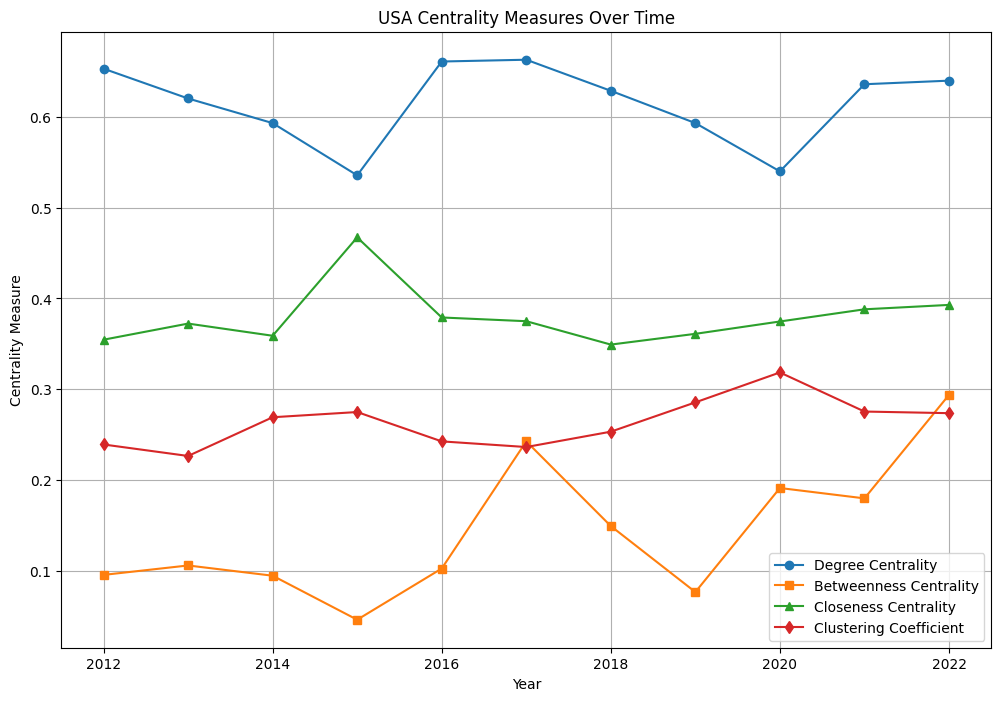

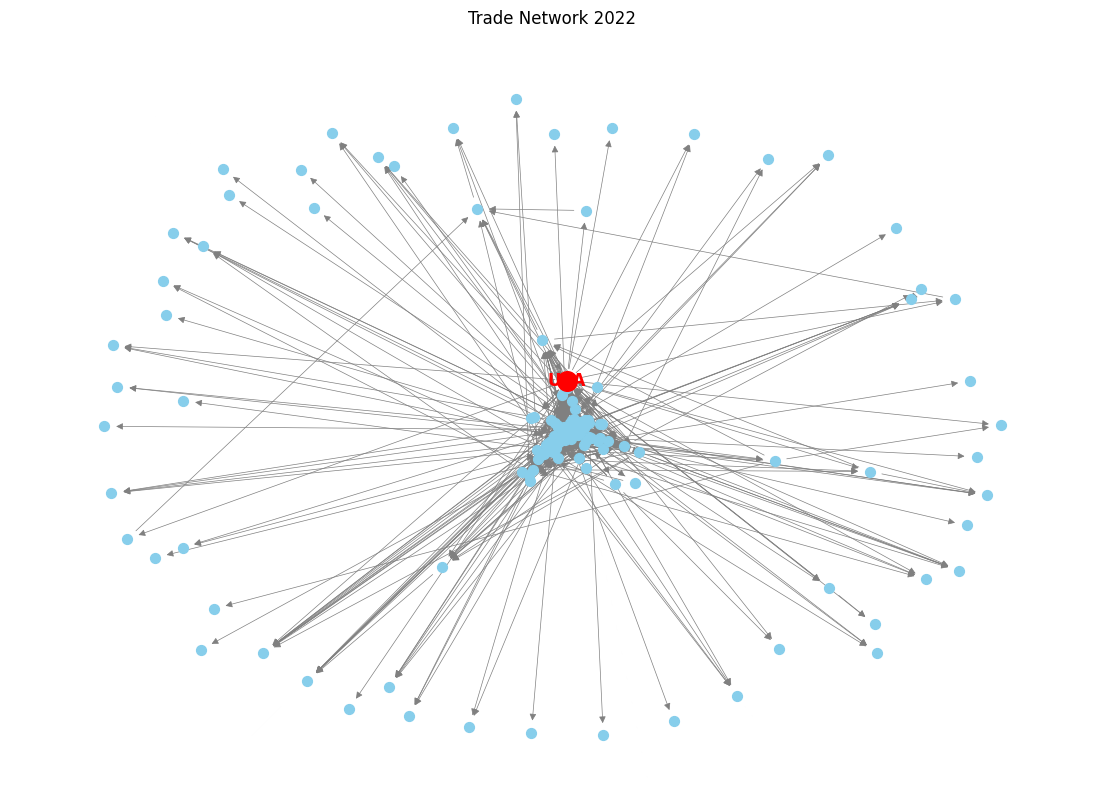

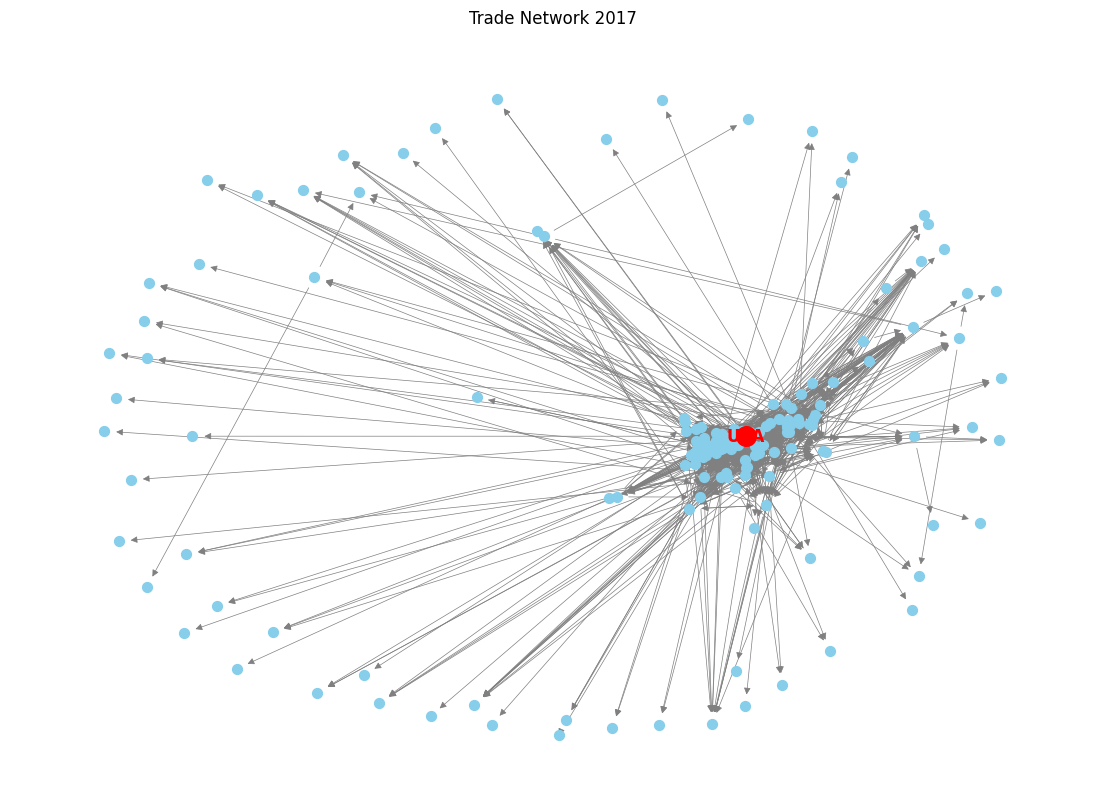

Year 2012: Detected 6 communities.
Year 2013: Detected 6 communities.
Year 2014: Detected 5 communities.
Year 2015: Detected 6 communities.
Year 2016: Detected 5 communities.
Year 2017: Detected 6 communities.
Year 2018: Detected 7 communities.
Year 2019: Detected 5 communities.
Year 2020: Detected 6 communities.
Year 2021: Detected 5 communities.
Year 2022: Detected 7 communities.


In [3]:
################
# Aluminium
################
data_path = os.path.join(os.getcwd(), "basedata", "base_data.csv")
hs_code = 760110
country_name = 'USA'
pre_treatment_years = [2012, 2013, 2014, 2015, 2016, 2021, 2022]  # Pre/Post-Trump era
treatment_years = [2017, 2018, 2019, 2020]  # Trump era

test_results = analyze_trade_network(data_path, hs_code, country_name, pre_treatment_years, treatment_years)


Statistical Tests:
T-test for DegreeCentrality: t-statistic = 1.5979, p-value = 0.1455
T-test for BetweennessCentrality: t-statistic = 0.6271, p-value = 0.5524
T-test for ClosenessCentrality: t-statistic = -0.6458, p-value = 0.5469
T-test for ClusteringCoefficient: t-statistic = -2.4370, p-value = 0.0475


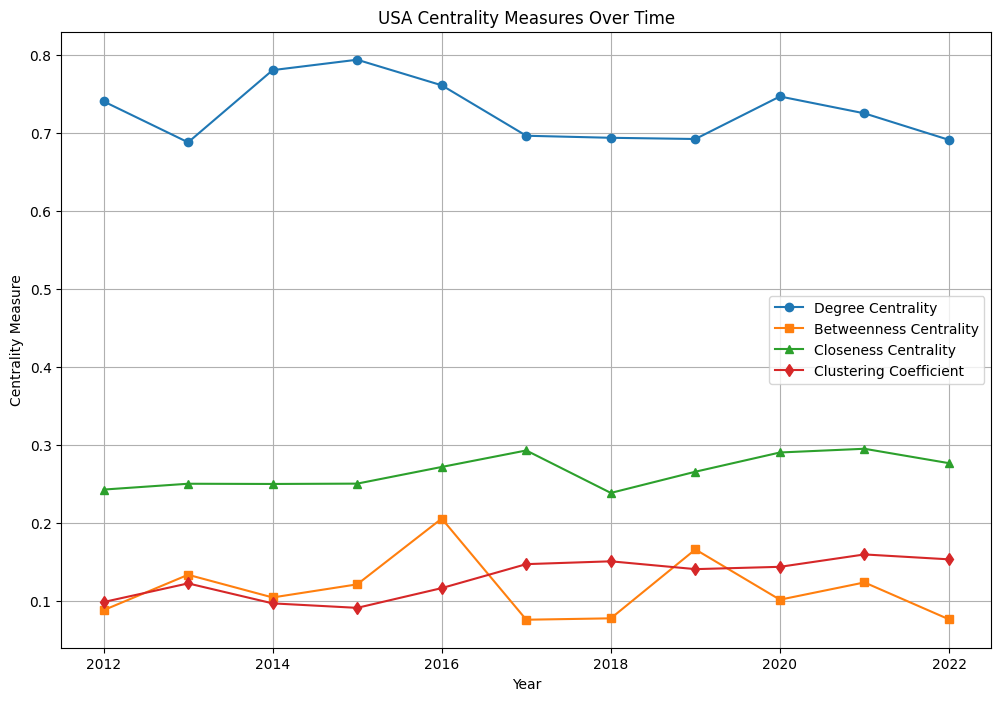

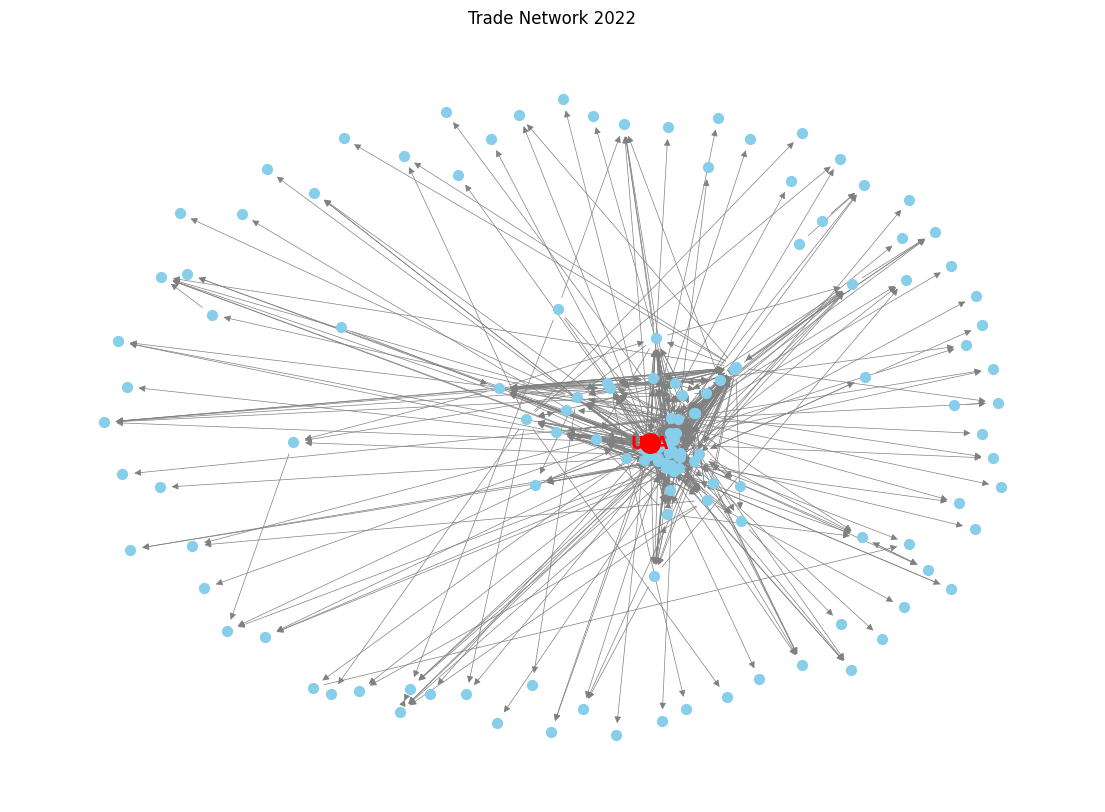

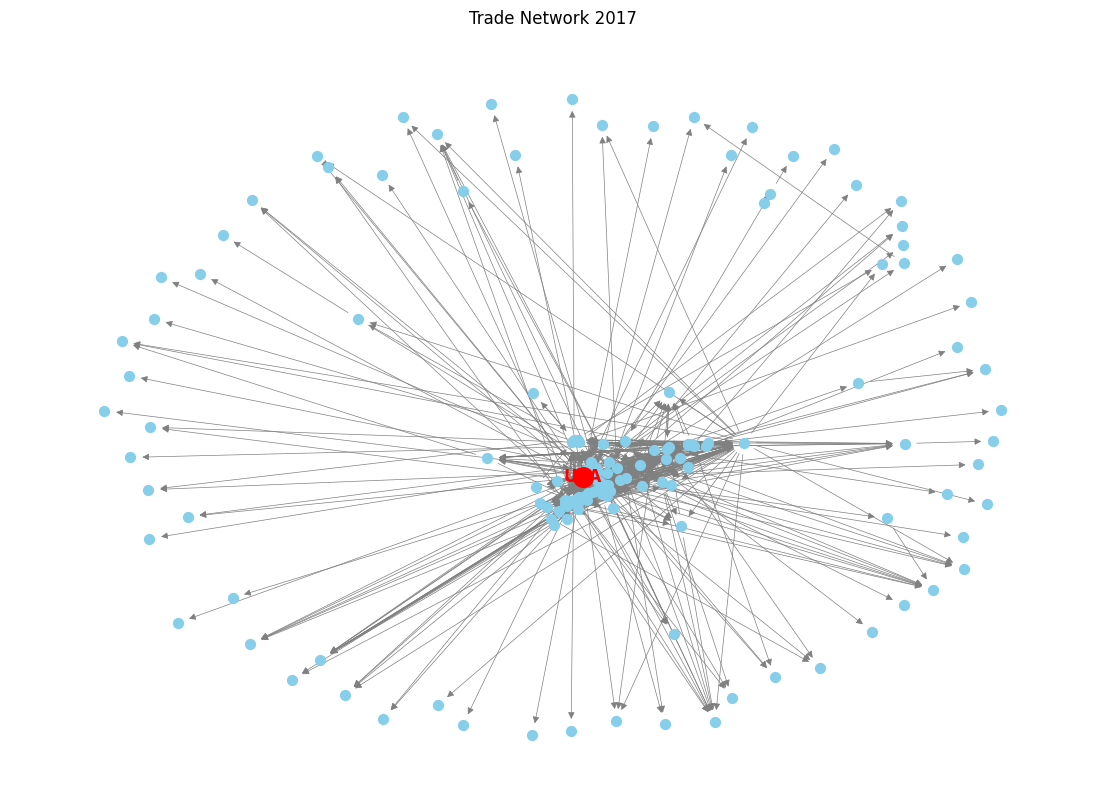

Year 2012: Detected 11 communities.
Year 2013: Detected 9 communities.
Year 2014: Detected 8 communities.
Year 2015: Detected 8 communities.
Year 2016: Detected 8 communities.
Year 2017: Detected 8 communities.
Year 2018: Detected 13 communities.
Year 2019: Detected 10 communities.
Year 2020: Detected 9 communities.
Year 2021: Detected 8 communities.
Year 2022: Detected 11 communities.


In [5]:
################
# Steel
################
data_path = os.path.join(os.getcwd(), "basedata", "base_data.csv")
hs_code = 721810
country_name = 'USA'
pre_treatment_years = [2012, 2013, 2014, 2015, 2016, 2021, 2022]  # Pre/Post-Trump era
treatment_years = [2017, 2018, 2019, 2020]  # Trump era

test_results = analyze_trade_network(data_path, hs_code, country_name, pre_treatment_years, treatment_years)

In [ ]:
################
# Crude
################
data_path = os.path.join(os.getcwd(), "basedata", "base_data.csv")
hs_code = 270900
country_name = 'USA'
pre_treatment_years = [2012, 2013, 2014, 2015, 2016, 2021, 2022]  # Pre/Post-Trump era
treatment_years = [2017, 2018, 2019, 2020]  # Trump era

test_results = analyze_trade_network(data_path, hs_code, country_name, pre_treatment_years, treatment_years)



Statistical Tests:
T-test for DegreeCentrality: t-statistic = 0.8669, p-value = 0.4098
T-test for BetweennessCentrality: t-statistic = -0.7804, p-value = 0.4586
T-test for ClosenessCentrality: t-statistic = 0.2867, p-value = 0.7813
T-test for ClusteringCoefficient: t-statistic = -0.7505, p-value = 0.4731


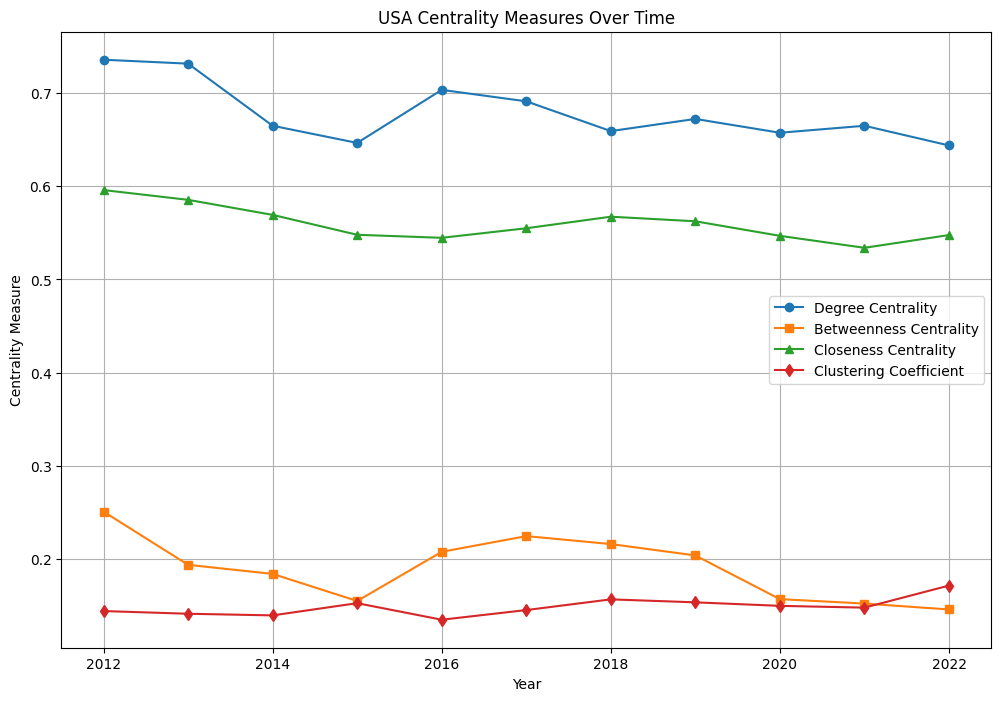

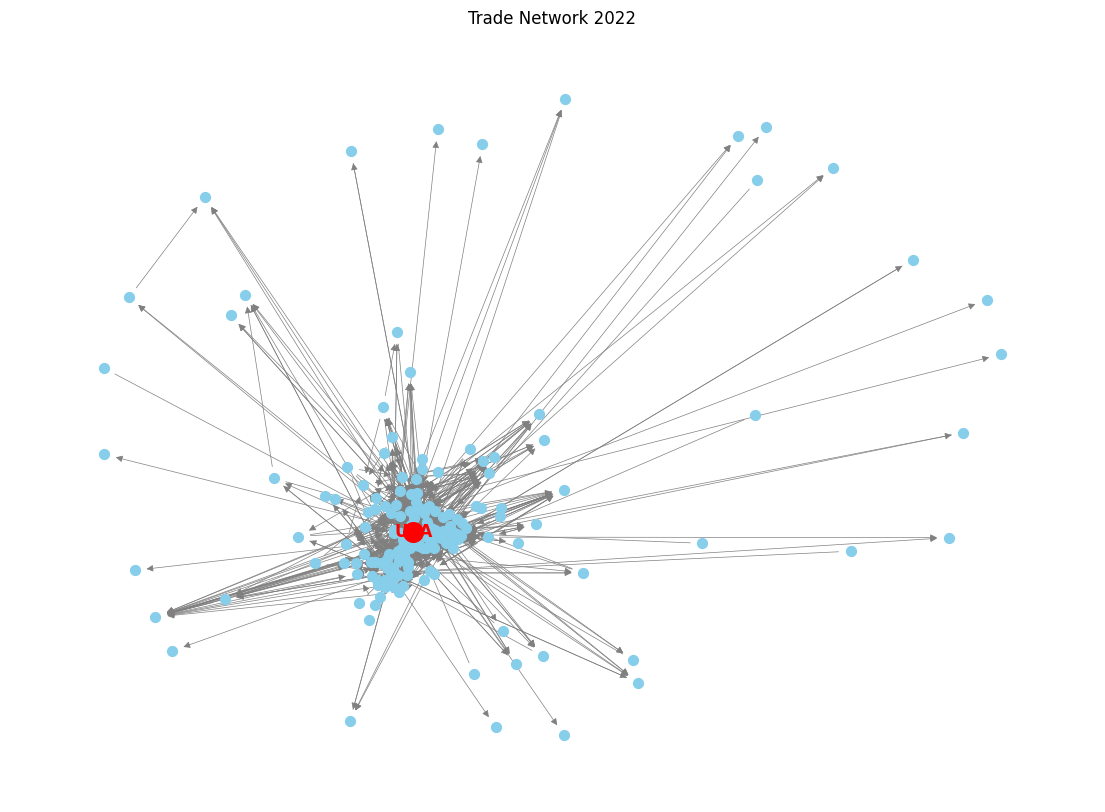

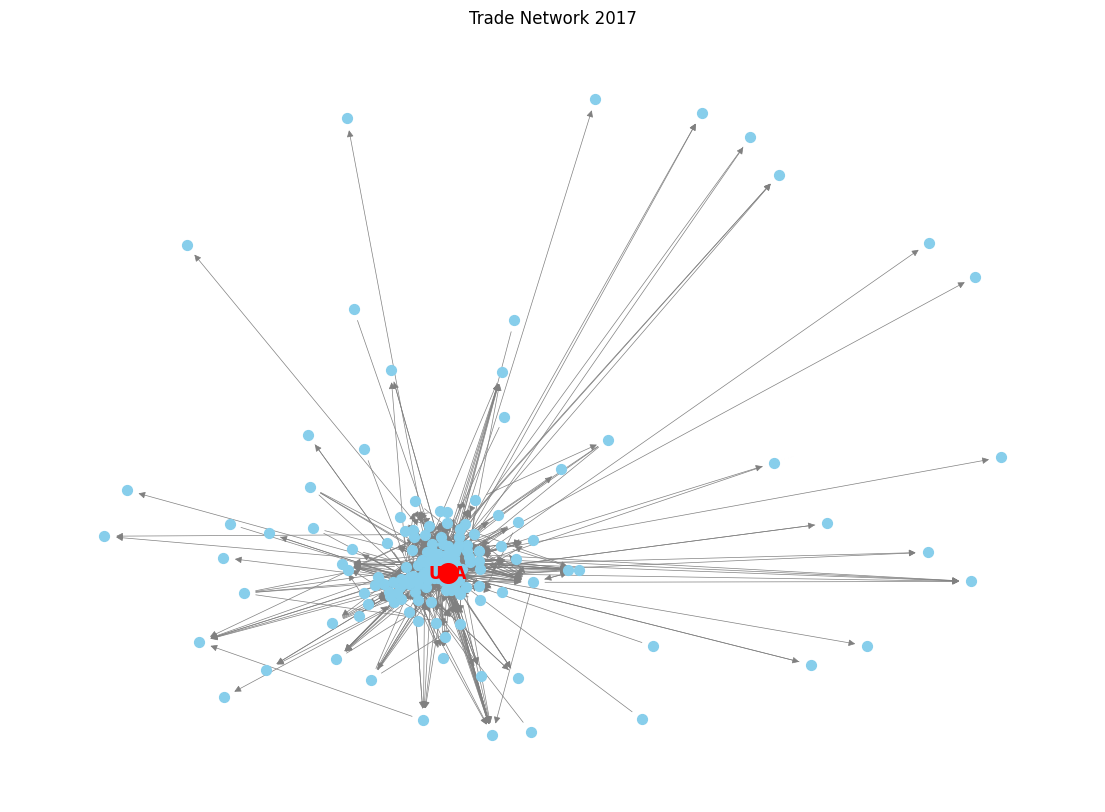

Year 2012: Detected 7 communities.
Year 2013: Detected 7 communities.
Year 2014: Detected 5 communities.
Year 2015: Detected 6 communities.
Year 2016: Detected 6 communities.
Year 2017: Detected 7 communities.
Year 2018: Detected 6 communities.
Year 2019: Detected 8 communities.
Year 2020: Detected 7 communities.
Year 2021: Detected 6 communities.
Year 2022: Detected 6 communities.


In [6]:
################
# Gold -> Baseline
################
data_path = os.path.join(os.getcwd(), "basedata", "base_data.csv")
hs_code = 710812
country_name = 'USA'
pre_treatment_years = [2012, 2013, 2014, 2015, 2016, 2021, 2022]  # Pre/Post-Trump era
treatment_years = [2017, 2018, 2019, 2020]  # Trump era

test_results = analyze_trade_network(data_path, hs_code, country_name, pre_treatment_years, treatment_years)

